In [3]:
import os.path as osp
from utils import *
import mmcv
import torch
import wandb
from mmcv import Config
from mmcv.parallel import MMDistributedDataParallel
from mmdet.apis import set_random_seed, train_detector
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from algo2_result_to_aligned_result import algo2_result_to_aligned_result
# Let's take a look at the dataset image
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from xml_to_np import xml_to_np, all_xml_to_np
from AP import calc_iou_individual, get_single_image_results
from soft_nms import py_cpu_softnms
from dbscan_result_to_aligned_result import dbscan_result_to_aligned_result
from AP import calc_iou_individual
import xml.etree.ElementTree as ET
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from utils import print_LC, detect_quads
import subprocess
import random

def get_free_gpu(force_gpu=None):
    if force_gpu!= None:
        return force_gpu
    else:
        log = str(
            subprocess.check_output("nvidia-smi --format=csv --query-gpu=utilization.gpu,memory.used", shell=True)
        ).split(r"\n")[1:-1]
        free_gpu = []
        for idx, gpu_info in enumerate(log):
            if gpu_info[:-4].split(" %, ")[0] == "0" and gpu_info[:-4].split(" %, ")[1] == "3":
                free_gpu.append(idx)
        if free_gpu:
            return random.choice(free_gpu)
        raise RuntimeError("All gpus are used")

In [4]:
detect_quads(f"/home/aiarhipov/datasets/WTW-dataset/test/images/11e8c54bfc1c398f048045b61d12db94.jpg")

2023-06-17 23:06:44,422 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.0.conv is upgraded to version 2.
2023-06-17 23:06:44,440 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.2.conv is upgraded to version 2.
2023-06-17 23:06:44,442 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.4.conv is upgraded to version 2.


load checkpoint from local path: /home/aiarhipov/centernet/exps/32_quad_long/latest.pth
torch.Size([1, 1, 328, 184])
torch.Size([1, 1, 328, 184])
torch.Size([1, 1, 328, 184])
torch.Size([1, 1, 328, 184])


tensor([[6.4833e+01, 4.0087e+02, 1.6392e+02,  ..., 6.4721e+01, 4.5820e+02,
         8.6682e-01],
        [6.0709e+01, 5.1670e+02, 1.5975e+02,  ..., 6.0687e+01, 5.7556e+02,
         8.6254e-01],
        [7.0092e+01, 2.8623e+02, 1.6793e+02,  ..., 7.0067e+01, 3.4321e+02,
         8.6032e-01],
        ...,
        [2.5037e+02, 2.8816e+02, 6.2473e+02,  ..., 2.4977e+02, 3.4476e+02,
         1.6083e-02],
        [1.4316e+02, 3.9755e+02, 3.5617e+02,  ..., 1.4263e+02, 4.5655e+02,
         1.6075e-02],
        [1.3108e+02, 7.6009e+02, 3.8531e+02,  ..., 1.3062e+02, 8.1363e+02,
         1.6074e-02]], device='cuda:3', grad_fn=<AsStridedBackward>)

In [5]:
checkpoint_file = '/home/aiarhipov/centernet/exps/32_quad_long/latest.pth'

config_file = "/home/aiarhipov/centernet/exps/32_quad_long/config.py"
cfg = Config.fromfile(config_file)

set_random_seed(0, deterministic=False)

dataset = build_dataset(cfg.data.test)

model = build_detector(cfg.model, train_cfg=cfg.model.test_cfg)#, test_cfg=cfg.model.test_cfg)
model.CLASSES = dataset.CLASSES

model = init_detector(config_file, checkpoint_file, device=f'cuda:{get_free_gpu(5)}')

loading annotations into memory...
Done (t=11.92s)
creating index...
index created!


2023-06-17 23:07:06,673 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.0.conv is upgraded to version 2.
2023-06-17 23:07:06,676 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.2.conv is upgraded to version 2.
2023-06-17 23:07:06,677 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.4.conv is upgraded to version 2.


load checkpoint from local path: /home/aiarhipov/centernet/exps/32_quad_long/latest.pth


In [7]:
conf_threshold = 0.5
iou_threshold = 0.9
res = []
# for idx in tqdm(range(int(len(dataset)))):
idx = 7
anno = dataset.get_ann_info(idx=idx)
boxes = anno["bboxes"]
segm_path = anno["seg_map"]
# xml_path = f"/home/aiarhipov/datasets/WTW-dataset/test/xml/{segm_path[:-4]}.xml"
# img_path = f"/home/aiarhipov/datasets/WTW-dataset/test/images/{segm_path[:-4]}.jpg"
img_path = f"/home/aiarhipov/datasets/WTW-dataset/test/images/11e8c54bfc1c398f048045b61d12db94.jpg"
xml_path = f"/home/aiarhipov/datasets/WTW-dataset/test/xml/11e8c54bfc1c398f048045b61d12db94.xml"
# img_path = f"/home/aiarhipov/datasets/WTW-dataset/test/images/1vzhDVZkRiOr9FWYuJP7oQAAACMAAQED.jpg"
# xml_path = f"/home/aiarhipov/datasets/WTW-dataset/test/xml/1vzhDVZkRiOr9FWYuJP7oQAAACMAAQED.xml"
# img_path = f"/home/aiarhipov/datasets/WTW-dataset/test/images/mit_google_image_search-10918758-86d8fb6ae7082304fd621df58c68adee00278d96.jpg"
# xml_path = f"/home/aiarhipov/datasets/WTW-dataset/test/xml/mit_google_image_search-10918758-86d8fb6ae7082304fd621df58c68adee00278d96.xml"


print(img_path)
gt_boxes = xml_to_np(xml_path)
# print(f"gt_boxes[0] = {gt_boxes[:5]}")
pred = inference_detector(model, img_path)
print(pred.shape)
# pred = pred[int(len(pred)/2):]
# print(f"pred[0] = {pred[:5]}")
# conf_indexes = py_cpu_softnms(pred[:, :4], pred[:, 4], thresh=0.475, method=2)
# print(f"conf_indexes = {conf_indexes}")
# conf_pred = pred[conf_indexes]
# print(f"conf_pred[0] = {conf_pred[:5]}")
# if conf_pred.shape[0] > 1:
#     conf_pred = dbscan_result_to_aligned_result([conf_pred])
#     if conf_pred:
#         conf_pred = conf_pred[0]
#         print(gt_boxes[:, :4].shape)
#         print(conf_pred[:, :4].shape)

/home/aiarhipov/datasets/WTW-dataset/test/images/11e8c54bfc1c398f048045b61d12db94.jpg
torch.Size([1, 1, 328, 184])
torch.Size([1, 1, 328, 184])
(3000, 9)


In [8]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [9]:
pred

array([[ 64.83, 400.87, 163.92, ...,  64.72, 458.2 ,   0.87],
       [ 60.71, 516.7 , 159.75, ...,  60.69, 575.56,   0.86],
       [ 70.09, 286.23, 167.93, ...,  70.07, 343.21,   0.86],
       ...,
       [250.37, 288.16, 624.73, ..., 249.77, 344.76,   0.02],
       [143.16, 397.55, 356.17, ..., 142.63, 456.55,   0.02],
       [131.08, 760.09, 385.31, ..., 130.62, 813.63,   0.02]],
      dtype=float32)

In [10]:
import warnings
from pathlib import Path

import mmcv
import numpy as np
import torch
from mmcv.ops import RoIPool
from mmcv.parallel import collate, scatter
from mmcv.runner import load_checkpoint

from mmdet.core import get_classes
from mmdet.datasets import replace_ImageToTensor
from mmdet.datasets.pipelines import Compose
from mmdet.models import build_detector
imgs = img_path
if isinstance(imgs, (list, tuple)):
    is_batch = True
else:
    imgs = [imgs]
    is_batch = False

cfg = model.cfg
device = next(model.parameters()).device  # model device

if isinstance(imgs[0], np.ndarray):
    cfg = cfg.copy()
    # set loading pipeline type
    cfg.data.test.pipeline[0].type = 'LoadImageFromWebcam'

cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)
test_pipeline = Compose(cfg.data.test.pipeline)

datas = []
for img in imgs:
    # prepare data
    if isinstance(img, np.ndarray):
        # directly add img
        data = dict(img=img)
    else:
        # add information into dict
        data = dict(img_info=dict(filename=img), img_prefix=None)
    # build the data pipeline
    data = test_pipeline(data)
    datas.append(data)

data = collate(datas, samples_per_gpu=len(imgs))
# just get the actual data from DataContainer
data['img_metas'] = [img_metas.data[0] for img_metas in data['img_metas']]
data['img'] = [img.data[0] for img in data['img']]
if next(model.parameters()).is_cuda:
    # scatter to specified GPU
    data = scatter(data, [device])[0]
else:
    for m in model.modules():
        assert not isinstance(
            m, RoIPool
        ), 'CPU inference with RoIPool is not supported currently.'

# forward the model
with torch.no_grad():
    results = model(return_loss=False, rescale=True, **data)

# model.forward(data['img'], data['img_metas'], return_loss=False)
center_heatmap_preds, offset_preds, center2vertex_pred, vertex2center_pred = model.bbox_head(model.extract_feat(data['img'][0]))
# gb = model.bbox_head.get_bboxes(center_heatmap_preds, offset_preds, center2vertex_pred, vertex2center_pred, data['img_metas'][0])
result_list = []
for img_id in range(len(data['img_metas'])):
    result_list.append(
        model.bbox_head._get_bboxes_single(
            center_heatmap_preds[0][img_id : img_id + 1, 0:1, ...],
            center2vertex_pred[0][img_id : img_id + 1, ...],
            offset_preds[0][img_id : img_id + 1, ...],
            data['img_metas'][img_id][0],
            rescale=False,
            with_nms=False,
        )
    )
print(result_list[0][0].shape, result_list[0][1].shape)

torch.Size([1, 1, 328, 184])
torch.Size([1, 1, 328, 184])
torch.Size([1, 1, 328, 184])
torch.Size([1, 1, 328, 184])
torch.Size([3000, 9]) torch.Size([3000])


In [11]:
data['img_metas'][0][0]

{'filename': '/home/aiarhipov/datasets/WTW-dataset/test/images/11e8c54bfc1c398f048045b61d12db94.jpg',
 'ori_filename': '/home/aiarhipov/datasets/WTW-dataset/test/images/11e8c54bfc1c398f048045b61d12db94.jpg',
 'ori_shape': (1280, 720, 3),
 'img_shape': (1280, 720, 3),
 'pad_shape': (1312, 736, 3),
 'scale_factor': array([1., 1., 1., 1.], dtype=float32),
 'flip': False,
 'flip_direction': None,
 'img_norm_cfg': {'mean': array([103.53, 116.28, 123.68], dtype=float32),
  'std': array([1., 1., 1.], dtype=float32),
  'to_rgb': False},
 'border': array([  16., 1296.,    8.,  728.], dtype=float32),
 'batch_input_shape': (1312, 736)}

torch.Size([1, 2, 328, 184])
torch.Size([1, 1, 328, 184])
tensor([[ 43.,  17.,  42.,  16.,  15.,  42.,  14.,  18.,  40.,  43.,  16.,  19.,
          18.,  13.,  43.,  41.,  15.,  14.,  16.,  19., 161.,  42.,  41.,  19.,
          41.,  44.,  41., 160., 161.,  43.,  17.,  43., 160., 161., 161.,  39.,
         160.,  39., 160.,  38.,  15., 161.,  42.,  40., 161.,  17., 160.,  44.,
          40.,  42.,  40., 161.,  18.,  41.,  43.,  19.,  14.,  13.,  39.,  38.,
          39.,  19.,  41.,  40.,  14.,  17.,  17.,  12.,  15., 159.,  40., 160.,
          42.,  39., 161.,  20., 161.,  13., 160.,  42.,  42., 161., 160.,  18.,
          18.,  16., 162.,  18.,  40., 161., 160., 159., 162., 161.,  14., 160.,
         159.,  44., 160., 161.,  43.,  18.,  40., 161.,  37.,  16.,  37.,  42.,
          19.,  44.,  37., 161., 162., 162.,  40.,  15.,  42.,  39.,  37., 159.,
         159.,  12.,  37.,  14.,  13., 161.,  40.,  17.,  36.,  12., 161.,  15.,
          11.,  39.,  43.,  41.,  43.,  41.,  44., 

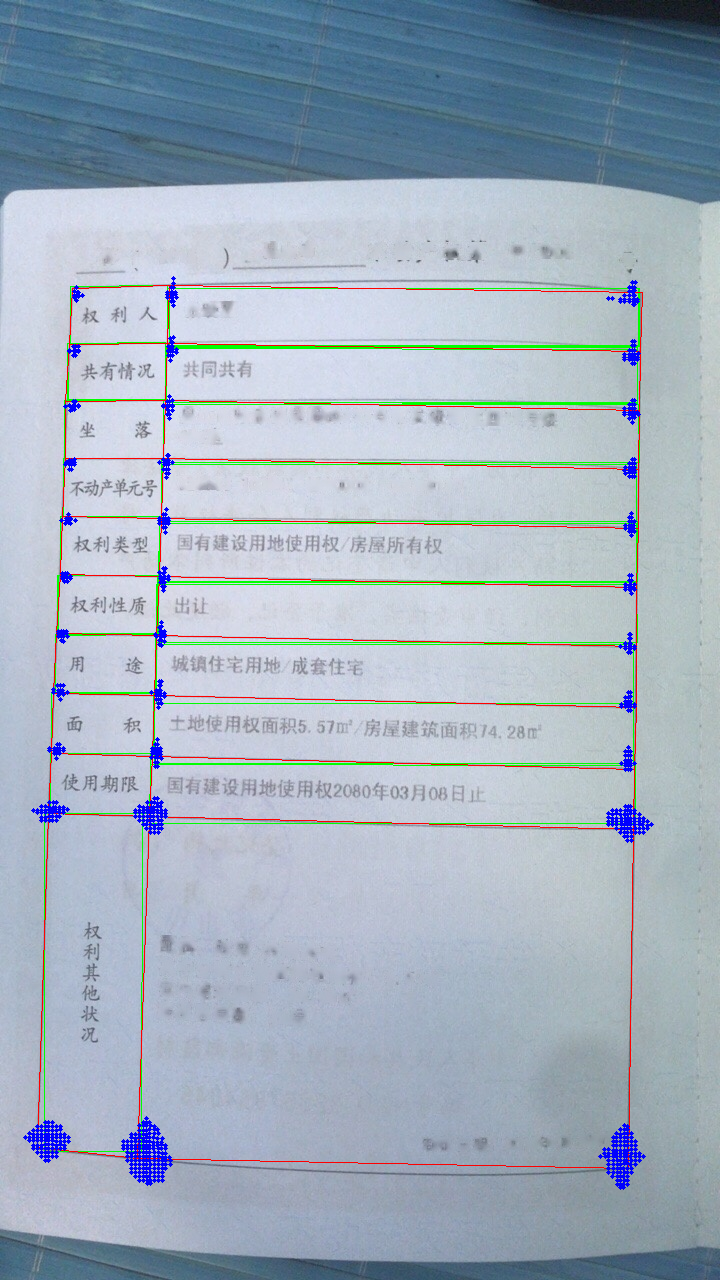

In [29]:
quads = result_list[0][0][:25]
import cv2
import numpy as np
from PIL import Image
from mmdet.models.utils.gaussian_target import get_local_maximum, get_topk_from_heatmap, transpose_and_gather_feat

# im = Image.open("/home/aiarhipov/centernet/imgs/tmp.jpg")
img = cv2.imread(img_path)
quads = quads.cpu().detach().numpy().astype(int)
for quad in quads:
    cv2.line(img, (quad[0], quad[1]), (quad[2], quad[3]), (0, 255, 0), thickness=1)
    cv2.line(img, (quad[2], quad[3]), (quad[4], quad[5]), (0, 255, 0), thickness=1)
    cv2.line(img, (quad[4], quad[5]), (quad[6], quad[7]), (0, 255, 0), thickness=1)
    cv2.line(img, (quad[6], quad[7]), (quad[0], quad[1]), (0, 255, 0), thickness=1)
    
gt_boxes = all_xml_to_np(xml_path)
gt_boxes = gt_boxes.astype(int)
for quad in gt_boxes:
    cv2.line(img, (quad[0], quad[1]), (quad[2], quad[3]), (255, 0, 0), thickness=1)
    cv2.line(img, (quad[2], quad[3]), (quad[4], quad[5]), (255, 0, 0), thickness=1)
    cv2.line(img, (quad[4], quad[5]), (quad[6], quad[7]), (255, 0, 0), thickness=1)
    cv2.line(img, (quad[6], quad[7]), (quad[0], quad[1]), (255, 0, 0), thickness=1)
    

height, width = center_heatmap_preds[0].shape[2:]
inp_h, inp_w = img.shape[:2]
print(center_heatmap_preds[0].shape)
center_heatmap_pred = get_local_maximum(center_heatmap_preds[0][:, 1:2, ...], kernel=1)
print(center_heatmap_pred.shape)
*batch_dets, topk_ys, topk_xs = get_topk_from_heatmap(center_heatmap_pred, k=1000)
batch_scores, batch_index, batch_topk_labels = batch_dets
offset = transpose_and_gather_feat(offset_preds[0], batch_index)
print(topk_xs, topk_ys)

topk_xs = topk_xs + offset[..., 0]
topk_ys = topk_ys + offset[..., 1]
print(topk_xs, topk_ys)
for x, y in zip(topk_xs[0].cpu().detach().numpy(), topk_ys[0].cpu().detach().numpy()):
    
    cv2.circle(img, (int(x * (inp_w / width)), int(y * (inp_h / height))), radius=2, color=(0, 0, 255), thickness=-1)
Image.fromarray(img)

In [13]:
topk_xs

tensor([[0.4569, 0.4599, 0.5120, 0.4573, 0.4344, 0.4996, 0.4516, 0.5155, 0.5448,
         0.5215, 0.4188, 0.4983, 0.4413, 0.4886, 0.4080, 0.4274, 0.4890, 0.3730,
         0.4565, 0.4692, 0.4437, 0.0919, 0.3697, 0.4519, 0.4094, 0.5604, 0.4041,
         0.4558, 0.4880, 0.4883]], device='cuda:5', grad_fn=<AddBackward0>)

In [14]:
# gt_boxes[:, :4]
# np.ones(gt_boxes.shape[0])
# center_heatmap_preds[0].shape
# data['img_metas']
# center2vertex_pred[0]
# vertex2center_pred[0]
# model.bbox_head.get_targets(torch.tensor(gt_boxes[:, :4], device="cuda:2"), torch.tensor(np.ones(gt_boxes.shape[0]), device="cuda:2"), center_heatmap_preds[0].shape, data['img'][0].shape, center2vertex_pred[0], vertex2center_pred[0])

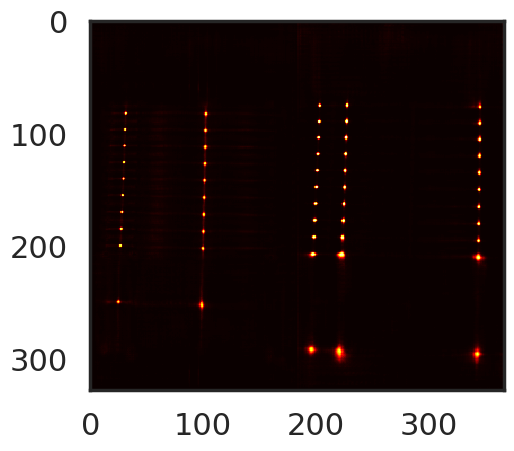

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.hstack([center_heatmap_preds[0][0][0].cpu().detach().numpy(), center_heatmap_preds[0][0][1].cpu().detach().numpy()]), cmap='hot', interpolation='nearest')
plt.show()

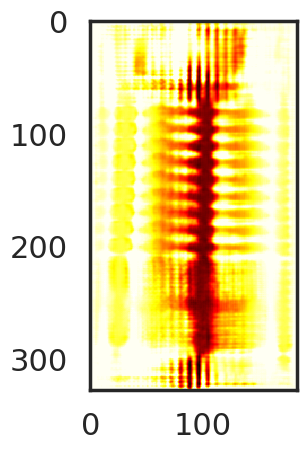

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(center2vertex_pred[0][0][0].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

In [17]:
# conf_pred = conf_pred.astype(int)
# conf_pred[0, 0], conf_pred[0, 2]
# conf_pred = conf_pred[(conf_pred[:, 0] != conf_pred[:, 2]) & (conf_pred[:, 1] != conf_pred[:, 3])]

In [18]:
# [conf_pred[(conf_pred[:, 0] < 20)&(conf_pred[:, 1] <30)]]
# conf_pred[(conf_pred.astype(int)[:, 0] == conf_pred.astype(int)[:, 2])]

In [19]:
# show_result_pyplot(model, img_path, [conf_pred[(conf_pred.astype(int)[:, 0] != conf_pred.astype(int)[:, 2])]], score_thr = 0.)
show_result_pyplot(model, img_path, [conf_pred], score_thr = 0.)

NameError: name 'conf_pred' is not defined

In [ ]:
show_result_pyplot(model, img_path, [gt_boxes[:, :4]], score_thr = 0., out_file="/home/aiarhipov/centernet/imgs/tmp.jpg")

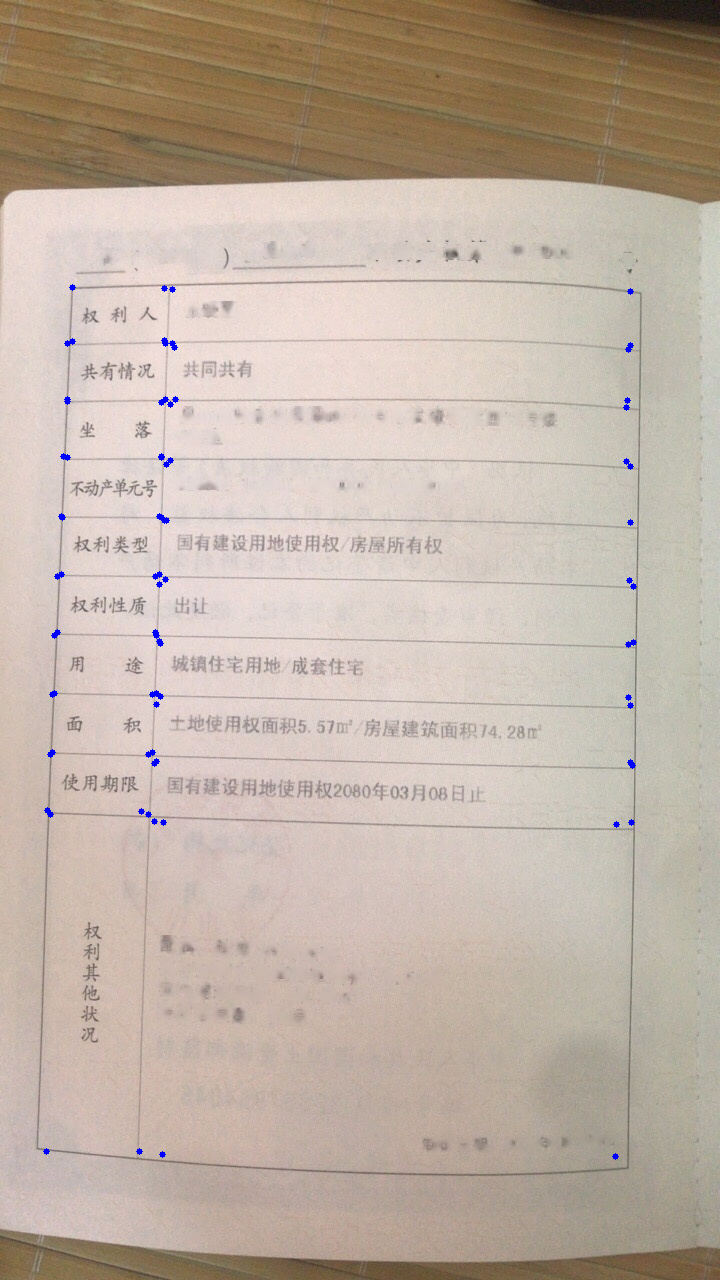

In [ ]:
import cv2
import numpy as np
from PIL import Image

# im = Image.open("/home/aiarhipov/centernet/imgs/tmp.jpg")
im = Image.open(img_path)
height, width = center_heatmap_preds[0][0][0].cpu().detach().numpy().shape[:2]
# Make into Numpy array so we can use OpenCV drawing functions

na = np.array(im)
inp_h, inp_w = na.shape[:2]
for j in range(conf_pred.shape[0]):
    cx = (conf_pred[j, 0] + conf_pred[j, 2]) // 2
    cy = (conf_pred[j, 1] + conf_pred[j, 3]) // 2
    cx ,cy = int(cx) ,int(cy)
    # dx = center2vertex_pred[0][0][0+2*i].cpu().detach().numpy()[cy * height // inp_h, cx * width // inp_w]
    # dy = center2vertex_pred[0][0][1+2*i].cpu().detach().numpy()[cy * height // inp_h, cx * width // inp_w]
    # dx ,dy = int(dx* (inp_w / width)) ,int(dy* (inp_h / height))
    # Draw arrowed line, from 10,20 to w-40,h-60 in black with thickness 8 pixels
    for i in range(4):
         
        dx = center2vertex_pred[0][0][0+2*i].cpu().detach().numpy()[cy * height // inp_h, cx * width // inp_w]
        dy = center2vertex_pred[0][0][1+2*i].cpu().detach().numpy()[cy * height // inp_h, cx * width // inp_w]
        dx ,dy = int(dx* (inp_w / width)) ,int(dy* (inp_h / height))
        # Draw arrowed line, from 10,20 to w-40,h-60 in black with thickness 8 pixels
        # na = cv2.line(na, (cx, cy), (cx+dx, cy+dy), (255,160,122), 2)
        na = cv2.circle(na, (cx+dx, cy+dy), radius=3, color=(0, 0, 255), thickness=-1)
        
# # Revert back to PIL Image and save
Image.fromarray(na)

In [ ]:
# iou_threshold = 0.9
# res = []
# from tqdm.notebook import tqdm
# for idx in tqdm(range(int(len(dataset))), position=0):
#     anno = dataset.get_ann_info(idx=idx)
#     boxes = anno["bboxes"]
#     segm_path = anno["seg_map"]
#     xml_path = f"/home/aiarhipov/datasets/WTW-dataset/test/xml/{segm_path[:-4]}.xml"
#     img_path = f"/home/aiarhipov/datasets/WTW-dataset/test/images/{segm_path[:-4]}.jpg"
    
#     gt_boxes = xml_to_np(xml_path)
    
#     pred = inference_detector(model, img_path)[0]
    
#     conf_indexes = py_cpu_softnms(pred[:, :4], pred[:, 4], thresh=0.475, method=2)
#     # print(pred[conf_indexes])
#     conf_pred = pred[conf_indexes]
#     # conf_pred = pred[pred[:, 4] > conf_threshold]
#     # conf_pred = pred[:int(gt_boxes.shape[0] * 1.5)]
#     metrics = get_single_image_results(gt_boxes[:, :4].tolist(), conf_pred[:, :4].tolist(), iou_thr=iou_threshold)
    
#     if (metrics["true_pos"] + metrics["false_pos"]) != 0:
#         metrics["Precision"] = metrics["true_pos"] / (metrics["true_pos"] + metrics["false_pos"])
#     else:
#         metrics["Precision"] = 0
        
#     if (metrics["true_pos"] + metrics["false_neg"]) != 0:
#         metrics["Recall"] = metrics["true_pos"] / (metrics["true_pos"] + metrics["false_neg"])
#     else:
#         metrics["Recall"]
        
#     if (metrics["Precision"] + metrics["Recall"]) != 0:
#         metrics["F1"] = 2 * metrics["Precision"] * metrics["Recall"] / (metrics["Precision"] + metrics["Recall"])
#     else:
#         metrics["F1"] = 0
        
#     res.append(metrics)
#     if idx % 10 == 0:
#         print(f"""Precision = {np.mean([d['Precision'] for d in res])}, Recall = {np.mean([d['Recall'] for d in res])}, F1 = {np.mean([d['F1'] for d in res])}""")
    
# print(f"Precision = {np.mean([d['Precision'] for d in res])}")
# print(f"Recall = {np.mean([d['Recall'] for d in res])}")
# print(f"F1 = {np.mean([d['F1'] for d in res])}")